**1.Importing necessary libraries**

In [23]:
import pandas as pd
import numpy as np
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import gc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import optuna
import xgboost as xgb
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn import datasets, linear_model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

**2.Loading datasets**

In [28]:
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')

In [59]:
sample = pd.read_csv('/content/sample_submission.csv')


**3.Miss information analysis** 

In [29]:
print(train.isnull().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


**4.Preprocessing**

In [30]:
train_test=train.append(test)
train_test=train_test.drop(['Name'],axis=1)

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Transported     4277
dtype: int64


<AxesSubplot:>

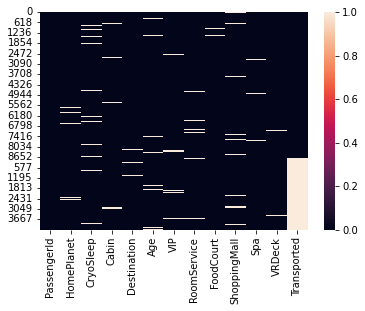

In [31]:
print(train_test.isnull().sum())
sns.heatmap(train_test.isnull())

**4.1.Expenses+CryoSleep**

In [32]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [33]:
train_test.loc[:,Expenses_columns]=train_test.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)

**4.2.CryoSleep + Expenses**

In [34]:
train_test['Expenses'] = train_test.loc[:,Expenses_columns].sum(axis=1)

In [35]:
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)

**4.3.Cabin**

In [36]:
train_test.loc[:,['Room']] = train_test.PassengerId.apply(lambda x: x[0:4] )
guide_VIP=train_test.loc[:,['Room','VIP']].dropna().drop_duplicates('Room')
guide_Cabin=train_test.loc[:,['Room','Cabin']].dropna().drop_duplicates('Room')
guide_HomePlanet=train_test.loc[:,['Room','HomePlanet']].dropna().drop_duplicates('Room')
guide_Destination=train_test.loc[:,['Room','Destination']].dropna().drop_duplicates('Room')
train_test=pd.merge(train_test,guide_Cabin,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_VIP,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_HomePlanet,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_Destination,how="left",on='Room',suffixes=('','_y'))

In [37]:
train_test.loc[:,['VIP']]=train_test.apply(lambda x: x.VIP_y if pd.isna(x.VIP) else x,axis=1)
train_test.loc[:,['Cabin']]=train_test.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
train_test.loc[:,['HomePlanet']]=train_test.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
train_test.loc[:,['Destination']]=train_test.apply(lambda x:  x.Destination_y if pd.isna(x.Destination) else x,axis=1)

In [38]:
train_test[train_test.Cabin.isnull()]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Expenses,Room,Cabin_y,VIP_y,HomePlanet_y,Destination_y
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,False,908.0,0012,NaN,False,Earth,TRAPPIST-1e
93,0101_01,Mars,True,NaN,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,True,0.0,0101,NaN,False,Mars,TRAPPIST-1e
222,0239_01,Mars,False,NaN,TRAPPIST-1e,37.0,False,637.0,0.0,0.0,92.0,319.0,False,1048.0,0239,NaN,False,Mars,TRAPPIST-1e
272,0301_01,Earth,True,NaN,TRAPPIST-1e,16.0,False,0.0,0.0,0.0,0.0,0.0,False,0.0,0301,NaN,False,Earth,TRAPPIST-1e
280,0310_01,Europa,False,NaN,TRAPPIST-1e,67.0,False,NaN,230.0,0.0,4476.0,241.0,False,4947.0,0310,NaN,False,Europa,TRAPPIST-1e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12869,9058_01,Mars,False,NaN,TRAPPIST-1e,38.0,NaN,784.0,0.0,42.0,38.0,10.0,NaN,874.0,9058,NaN,NaN,Mars,TRAPPIST-1e
12902,9138_01,Europa,NaN,NaN,TRAPPIST-1e,41.0,False,0.0,1998.0,0.0,1023.0,867.0,NaN,3888.0,9138,NaN,False,Europa,TRAPPIST-1e
12941,9223_01,Mars,True,NaN,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,0.0,NaN,0.0,9223,NaN,False,Mars,TRAPPIST-1e
12942,9223_02,Mars,True,NaN,TRAPPIST-1e,17.0,False,0.0,0.0,0.0,0.0,0.0,NaN,0.0,9223,NaN,False,Mars,TRAPPIST-1e


** 4.6.HomePlanet + Destination.**

In [41]:
analys = train_test.loc[:,['HomePlanet','Destination']]
analys['numeric'] =1
analys.groupby(['Destination','HomePlanet']).count()

numeric
Destination   HomePlanet         
55 Cancri e   Earth           995
              Europa         1343
              Mars            299
PSO J318.5-22 Earth          1083
              Europa           29
              Mars             68
TRAPPIST-1e   Earth          4737
              Europa         1780
              Mars           2328

**4.7.Split Cabin.**

In [43]:
train_test.loc[:,['Cabin_1']] = train_test.Cabin.str.split("/",expand=True).iloc[:,0]
train_test.loc[:,['Cabin_2']] = train_test.Cabin.str.split("/",expand=True).iloc[:,1]
train_test.loc[:,['Cabin_3']] = train_test.Cabin.str.split("/",expand=True).iloc[:,2]

**4.8.Let's apply SimpleImputer + OneHotEncoder.**

In [44]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
cat_cols = ['CryoSleep','Cabin_1','Cabin_3','VIP','HomePlanet','Destination']
transported=['Transported']
#notvg = ['HomePlanet','VIP','ShoppingMall','FoodCourt','Age','Cabin_2','Destination']
train_test = train_test[num_cols+cat_cols+transported].copy()

num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder (handle_unknown='ignore',sparse = False)


train_test[num_cols] = pd.DataFrame(num_imp.fit_transform(train_test[num_cols]),columns=num_cols)
train_test[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train_test[cat_cols]),columns=cat_cols)
temp_train = pd.DataFrame(ohe.fit_transform(train_test[cat_cols]),columns= ohe.get_feature_names_out())
train_test = train_test.drop(cat_cols,axis=1)
train_test = pd.concat([train_test,temp_train],axis=1)



**4.9.Let's split train and test set.**

In [45]:
train = train_test[train_test['Transported'].notnull()].copy()
train.Transported =train.Transported.astype('int')
test = train_test[train_test['Transported'].isnull()].drop("Transported",axis=1)

In [46]:
test

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,CryoSleep_False,CryoSleep_True,Cabin_1_A,...,Cabin_3_S,Cabin_3_None,VIP_False,VIP_True,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
8693,0.0,0.0,0.0,0.0,0.0,0.0,27.000000,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8694,0.0,9.0,0.0,2823.0,0.0,2832.0,19.000000,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8695,0.0,0.0,0.0,0.0,0.0,0.0,31.000000,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8696,0.0,6652.0,0.0,181.0,585.0,7418.0,38.000000,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8697,635.0,0.0,10.0,0.0,0.0,645.0,20.000000,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12966,17.0,847.0,0.0,10.0,144.0,1018.0,42.000000,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12967,0.0,0.0,0.0,0.0,0.0,0.0,28.771969,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
12968,0.0,2680.0,0.0,0.0,523.0,3203.0,28.771969,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [47]:
X = train.drop('Transported',axis=1)
y = train.Transported

In [48]:
X,y = shuffle(X,y)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

 ** 4.10.Let's deal with outliers.**

In [49]:
features_isolation =['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Age']

In [53]:
drop_list=['ShoppingMall','Age','CryoSleep_True','HomePlanet_Earth','HomePlanet_Europa',
'VIP_True','HomePlanet_Mars','Destination_PSO J318.5-22','VIP_False',
'Destination_55 Cancri e','FoodCourt','Destination_TRAPPIST-1e']

In [54]:
X=X.drop(drop_list,axis=1)
test=test.drop(drop_list,axis=1)


In [254]:

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [255]:
model1 = LGBMClassifier()
parameters1 = {"n_estimators":[100,300,500,600,650],
              "learning_rate":[0.01,0.02,0.03],
              "random_state":[0,42,48,50],
               "num_leaves":[16,17,18]}
grid_search1 = GridSearchCV(model1, parameters1, cv=5, n_jobs=-1)
grid_search1.fit(X,y.values.ravel())
grid_search1.best_score_
best_parameters1 = grid_search1.best_params_

In [256]:
model1 = LGBMClassifier(**best_parameters1)
model1.fit(X,y)
x_test_pred1 = model1.predict(test)


In [257]:
sample['Transported'] = x_test_pred1 
sample['Transported']=sample['Transported']>0.5
sample.to_csv('lgbm1.csv', index=False)

In [259]:
## CODE FOR LGBM HYPERPARSMETERS
skf = StratifiedKFold(n_splits=10)

In [260]:

def objective(trial):
    param = {
     'objective': 'binary',
     'device': 'hist',
     'metric': 'binary_logloss',
     'verbosity': -1,
     'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
     'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
     'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
     'num_leaves': trial.suggest_int('num_leaves', 2, 512),
     'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
     'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
     'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
     'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     'n_estimators' : trial.suggest_int('n_estimators', 100, 20000),
     'subsample':None,
     'subsample_freq':None,
     'reg_alpha':None,
     'colsample_bytree':None,
     'reg_lambda':None,
     'early_stopping_round':trial.suggest_int('early_stopping_round', 200, 200)
            }
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = lgb.LGBMClassifier(**param).fit(train_X,train_y,
                                            eval_set=[(valid_X,valid_y)],
                                            callbacks=[lgb.log_evaluation(period=0, show_stdv=False)]
                                             )  
        n_iteration = model.best_iteration_
        n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        i=int(sum(n_iterations)/len(n_iterations))
    print("Average n_ite=" + str(i))
    print("% of scatter =" + str(np.std(n_iterations)/i))
    n=sum(results)/len(results)
    print(n)
    print("FIIINISH__________________________________\n")
       
    return n

if optuna_study == LGBM_study:
    study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
    study.optimize(objective, n_trials=10000)
    print('Best trial:', study.best_trial.params)


In [56]:
params_LGBM= {'lambda_l1': 6.183557865875619, 
              'lambda_l2': 0.011470762415538793, 
              'learning_rate': 0.08693013162698361, 
              'num_leaves': 330,
              'feature_fraction': 0.6583455294128855, 
              'bagging_fraction': 0.8666491286986552, 
              'bagging_freq': 1, 
              'min_child_samples': 17, 
              'n_estimators': 739}

In [262]:
## HYPERPARAMETER TUNING XGB

In [263]:
def objective(trial):
    print("START__________________________________")
    param = {  
        'tree_method':'hist',
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,3000),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7,8,9,10]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree',1,1),
        }
    
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = xgb.XGBClassifier(**param).fit(train_X,train_y,
                                      eval_set=[(valid_X,valid_y)],
                                      verbose=0
                                     )  
        n_iteration = model.get_booster().best_iteration
        n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        i=int(sum(n_iterations)/len(n_iterations))
    print("Average n_ite=" + str(i))
    print("% of scatter =" + str(np.std(n_iterations)/i))    
    n=sum(results)/len(results) 
    print (n)
    print("FIIINISH__________________________________\n")
    return n

if optuna_study == XGB_study:
    study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                                direction='maximize')
    study.optimize(objective, n_trials=1000)

In [ ]:
study = optuna.create_study(direction='maximize', study_name='XGBoost Optimization')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)
print("Best objective value: ", study.best_value)

In [55]:
params_XGB_best= {'lambda': 3.0610042624477543, 
             'alpha': 4.581902571574289, 
             'colsample_bytree': 0.9241969052729379, 
             'subsample': 0.9527591724824661, 
             'learning_rate': 0.06672065863100594, 
             'n_estimators': 730,
             'max_depth': 5, 
             'min_child_weight': 1, 
             'num_parallel_tree': 1}

In [266]:
pred_XGB_best = (xgb.XGBClassifier(**params_XGB_best).fit(X,y)).predict(test)
sample['Transported'] = pred_XGB_best
sample['Transported']=sample['Transported']>0.5
sample.to_csv('XGB_best(2).csv', index=False)

In [ ]:

from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()
xgb = XGBRegressor()
lgbm_params = params_LGBM
xgb_params = params_XGB_best

lgbm_best_params = params_LGBM
xgb_best_params = params_XGB_best

lgbm_best = LGBMRegressor(**lgbm_best_params)
xgb_best = XGBRegressor(**xgb_best_params)
ensemble = VotingRegressor([('lgbm', lgbm_best), ('xgb', xgb_best)])
ensemble.fit(X, y)
y_pred = ensemble.predict(test)

In [64]:
sample['Transported'] = y_pred
sample['Transported']=sample['Transported']>0.5
sample.to_csv('ensemblelgbmxgboptum.csv', index=False)